# **Final Task**

Anna Tigranyan💚
---


## **Task**
Please find task instructions below:

Daily data of application sessions, one row per session


* **deviceID** - unique deviceID (to consider as unique user)

* **sessionEnd** - timestamp when session ended

* **durationMinutes** -time spent per session

Create a report about average time a user spends using the app daily. Also include data cleaning in the report.

Use pyspark for the whole analysis and a preferred visualization tool.
Report must be clean - plots with title, description, code commented, no draft code, keep report tidy and write down some bullet points

### **Importing Libraries**

In [477]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### **Data Loading**

Before the data loading we need to create a **Spark Session**.<br>
In short, SparkSession is the entry point to the Spark cluster, it is responsible for creating a connection to the Spark cluster, it provides a way to configure the Spark environment, and it provides a convenient way of creating DataFrames and manipulating data.

In [478]:
# Create a SparkSession
spark = SparkSession.builder.appName("DurationReport").getOrCreate()

# Load the data
df = spark.read.csv("case1_data.csv", header=True, inferSchema=True)

df.show(5)

+--------------------+--------------------+------------------+
|            deviceID|          sessionEnd|   durationMinutes|
+--------------------+--------------------+------------------+
|2676fa312abe4f8e8...|2022-02-18 20:24:...|  5.46837015115716|
|b12db36113e448119...|2022-02-18 19:44:...|15.766857310525666|
|a45bb307a66c40c29...|2022-02-18 20:34:...|52.877034520211055|
|726e8567281642a99...|2022-02-18 20:22:...|10.465253290657984|
|592c83f658bd42a28...|2022-02-18 20:40:...| 4.660509594963742|
+--------------------+--------------------+------------------+
only showing top 5 rows



We need to calculate **average time a user spends using the app daily**.<br>
Let's see what we need to do with an example:<br>
For example we have the user below:<br>

In [479]:
df.filter(df. deviceID == "62a4d577a5c540cc8aa7a63cb596597d").show(truncate=False)

+--------------------------------+--------------------------+------------------+
|deviceID                        |sessionEnd                |durationMinutes   |
+--------------------------------+--------------------------+------------------+
|62a4d577a5c540cc8aa7a63cb596597d|2022-02-18 07:47:35.993448|0.819340629167641 |
|62a4d577a5c540cc8aa7a63cb596597d|2022-02-18 21:05:02.384016|202.42046592434258|
|62a4d577a5c540cc8aa7a63cb596597d|2022-02-18 18:05:58.405373|55.615164226966726|
|62a4d577a5c540cc8aa7a63cb596597d|2022-02-18 08:43:32.027753|56.05348750571147 |
|62a4d577a5c540cc8aa7a63cb596597d|2022-02-18 21:08:11.241039|159.67504326536687|
+--------------------------------+--------------------------+------------------+



For this user the avarage daily duration is the sum of the duration Minutes column (**474.58 min**) because all the sessions are in the 2022-02-18 and we only need to sum all this and divide this number to the days number in which the user makes sessions(in this case the days number is 1(user used the app only in 2022-02-18 so the average daily for him/her is the sum) ).<br><br>
Let's see another example:

In [480]:
df.filter(df. deviceID == "0a85c05b3a54433a832fb0abb64b15a0").show(truncate=False)


+--------------------------------+--------------------------+------------------+
|deviceID                        |sessionEnd                |durationMinutes   |
+--------------------------------+--------------------------+------------------+
|0a85c05b3a54433a832fb0abb64b15a0|2022-02-18 00:00:15.675386|1910.7940012429908|
+--------------------------------+--------------------------+------------------+



For this user the avarage daily duration is **636.93 min** (1910.79 / 3).In this case we see that the user used the app 3 days in 16,17,18, so for his/her we need to devide all spending time(1910.79) to the days number he/she used the app(3).
<br>

Let's move on an do this:

In [481]:
# Cleaning the data
df = df.dropna()
df = df.dropDuplicates()

In [482]:
# ptinting the schema of the data frame to see data types of calumns
df.printSchema()

root
 |-- deviceID: string (nullable = true)
 |-- sessionEnd: timestamp (nullable = true)
 |-- durationMinutes: double (nullable = true)



For the future calculations we need to calculate the start time of the session for the per row of our data frame. We only need to subtract the duration from the sessionEnd to get the start time for the per row.

In [483]:
# Adding the start time column
df = df.withColumn("start_time", unix_timestamp(col("sessionEnd")) - (col("durationMinutes")*60 ))

# Converting the start time column to timestamp
df = df.withColumn("start_time", to_timestamp(df["start_time"]))

In [484]:
df.show(5)

+--------------------+--------------------+------------------+--------------------+
|            deviceID|          sessionEnd|   durationMinutes|          start_time|
+--------------------+--------------------+------------------+--------------------+
|4f65faf57bf947148...|2022-02-18 20:12:...| 84.61987762441981|2022-02-18 18:47:...|
|1938416ffdab498c8...|2022-02-18 20:27:...|12.338396381166376|2022-02-18 20:15:...|
|e6cb4778515c427d8...|2022-02-18 20:51:...|135.70301499981156|2022-02-18 18:35:...|
|3ddae1405a5641e28...|2022-02-18 20:55:...|308.06810626318315|2022-02-18 15:47:...|
|27706b28210e4a609...|2022-02-18 20:25:...|38.169100722160465|2022-02-18 19:47:...|
+--------------------+--------------------+------------------+--------------------+
only showing top 5 rows



In [485]:
df.printSchema()

root
 |-- deviceID: string (nullable = true)
 |-- sessionEnd: timestamp (nullable = true)
 |-- durationMinutes: double (nullable = true)
 |-- start_time: timestamp (nullable = true)



In [486]:
# Creating a window to partition by deviceID and order by sessionEnd
w = Window.partitionBy("date").orderBy("sessionEnd")

This code creates a **window** w object in PySpark that can be used to perform window functions. The window is defined by the partitionBy and orderBy functions.

The **partitionBy** function is used to partition the data into groups, in this case the data is partitioned by the "**deviceID**" column. This means that the window function will be applied separately to each group of rows with the same "deviceID" value.

The **orderBy** function is used to sort the data within each partition, in this case the data is sorted by the "**sessionEnd**" column. This means that the window function will be applied to the rows within each partition in the order of the "sessionEnd" column.

In [487]:
# Createing a new column to calculate the days passed
df = df.withColumn("days_passed",datediff(col("sessionEnd"),col("start_time"))+1)

The code above creates a new column "**days_passed**" by using the withColumn function, and performing a calculation on the existing columns "**sessionEnd**" and "**start_time**".

The **datediff** function calculates the difference between two date or timestamp columns in days, in our case the difference is calculated between the "**sessionEnd**" column and the "**start_time**" column.

The result of this calculation is then incremented by 1 using the **+1**, which is done to include the start and end date in the calculation.

This new column "**days_passed**" will represent the number of days between the "sessionEnd" and "start_time", including both days.

In [488]:
df.show(5)

+--------------------+--------------------+------------------+--------------------+-----------+
|            deviceID|          sessionEnd|   durationMinutes|          start_time|days_passed|
+--------------------+--------------------+------------------+--------------------+-----------+
|4f65faf57bf947148...|2022-02-18 20:12:...| 84.61987762441981|2022-02-18 18:47:...|          1|
|1938416ffdab498c8...|2022-02-18 20:27:...|12.338396381166376|2022-02-18 20:15:...|          1|
|e6cb4778515c427d8...|2022-02-18 20:51:...|135.70301499981156|2022-02-18 18:35:...|          1|
|3ddae1405a5641e28...|2022-02-18 20:55:...|308.06810626318315|2022-02-18 15:47:...|          1|
|27706b28210e4a609...|2022-02-18 20:25:...|38.169100722160465|2022-02-18 19:47:...|          1|
+--------------------+--------------------+------------------+--------------------+-----------+
only showing top 5 rows



In [489]:
# Createing a new column to calculate the date
df = df.withColumn("date", date_trunc("day", col("start_time")))

The code above creates a new column "**date**", and performing a calculation on the existing column "sessionEnd" using the date_trunc function.

The **date_trunc** function truncates a timestamp or date column to a specific unit of time, such as day, month, or year. In this case, the "sessionEnd" column is truncated to the day level, meaning that the new column "date" will contain the date part of the "sessionEnd" column, discarding the time part.

This new column "date" will contain the date of each row with the time part truncated.

To calculate the average daily duration for per user,we need to group by our df both the user ID and the date, we are going tou se the **groupBy** function twice, once for the "**deviceID**" column and once for the "**date**" column.

In [490]:
# Grouping the data by deviceID and date
df = df.groupBy("date", "deviceID")



The code below covers the avarage calculation for **this data set**.

In [492]:
#Calculate the average duration per user
df = df.agg((sum("durationMinutes")/(max(col('days_passed'))) ).alias("average_duration"))

This code above will calculate the **average duration** by dividing the **sum** of "**durationMinutes**" by the **max days passed**.
<br>
In our provided data we only have end date 18 and it means that we can only have 3 cases:

1. the user's all sessions are in the date 18 so we need only to sum all this 
minutes to have a daily activity,which above function does by dividing that sum to max days passes(in this case all are 1 so max is 1)
2. one of the user's session is devided 2 parts between 17 and 18. In this case we need to devide all minutes sum to 2 (number of days users was in a session,in our case it is 2(17,18)). Above function covers this too it devides the sum of the minutes to the max number of passed days(in our case max is 2).
3.the user end date is 18 but the user was in a session for a long time(for example 5000 minute).Above code covers this, we just need to divide this number to the days passed.



<br>
The result will be a new DataFrame with columns "deviceID", "date", and "average_duration".

For average daily report we don't need the date column, so let's remove it:

In [493]:
df = df.drop("date", "column")


In [494]:
# Show the report
df.show(10)

+--------------------+------------------+
|            deviceID|  average_duration|
+--------------------+------------------+
|6207ae7a0648467fa...|279.71218547848355|
|87e237d831574f8a8...| 99.32501415688978|
|689e9df6d2014112b...|111.95064683760683|
|d8980025e4a64a18a...|110.01332388410748|
|aba457162d644333a...|59.441949336728385|
|7f8b8ae500bd48058...|39.525094816446085|
|16c4816292004fac9...| 81.30435803779943|
|eb693836dacb4ceaa...|12.608495822582313|
|5454d14897764bf98...| 21.06584338025982|
|81abf9b42032491e9...| 48.39209025494665|
+--------------------+------------------+
only showing top 10 rows



Finally, we can see the results of our code for the users we used as examples at the beginning:

In [495]:
df.filter(df. deviceID == "62a4d577a5c540cc8aa7a63cb596597d").show(truncate=False)

+--------------------------------+-----------------+
|deviceID                        |average_duration |
+--------------------------------+-----------------+
|62a4d577a5c540cc8aa7a63cb596597d|474.5835015515553|
+--------------------------------+-----------------+



In [496]:
df.filter(df. deviceID == "0a85c05b3a54433a832fb0abb64b15a0").show(truncate=False)

+--------------------------------+-----------------+
|deviceID                        |average_duration |
+--------------------------------+-----------------+
|0a85c05b3a54433a832fb0abb64b15a0|636.9313337476636|
+--------------------------------+-----------------+



As we can see the result is correct!!!

### **Vizualization**

In [497]:
# sorting the dataframe by average duration in descending order
df1 = df.sort("average_duration", ascending=False)

In [498]:
# convert the dataframe to a pandas dataframe
df_pandas = df1.select("deviceID", "average_duration").toPandas()
# Rounding the avarage duration
df_pandas["average_duration"] = np.round(df_pandas["average_duration"],2)

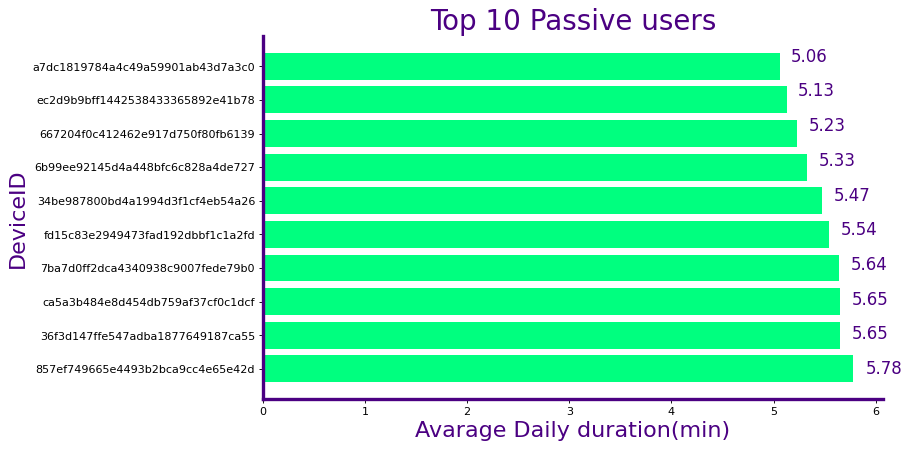

In [499]:
fig, ax = plt.subplots(figsize=(10,6),dpi=80)
ax.barh(df_pandas['deviceID'][-10:], df_pandas['average_duration'][-10:],color = 'springgreen');

# add annotations to the bars
for i, v in enumerate(df_pandas['average_duration'][-10:]):
    plt.annotate(str(v), xy=(v, i), xytext=(v+5, i),
                 textcoords='offset points', ha='left', va='center',color='indigo',fontsize = 15)
        
#labels & title
ax.set_title('Top 10 Passive users',fontsize = 25, color = 'indigo')
ax.set_ylabel('DeviceID',color ='indigo',size = "20")
ax.set_xlabel('Avarage Daily duration(min)',color ='indigo',size = "20") 

#ax design
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("indigo")
for axi in ['top','right']:  
    ax.spines[axi].set_color(None);
    

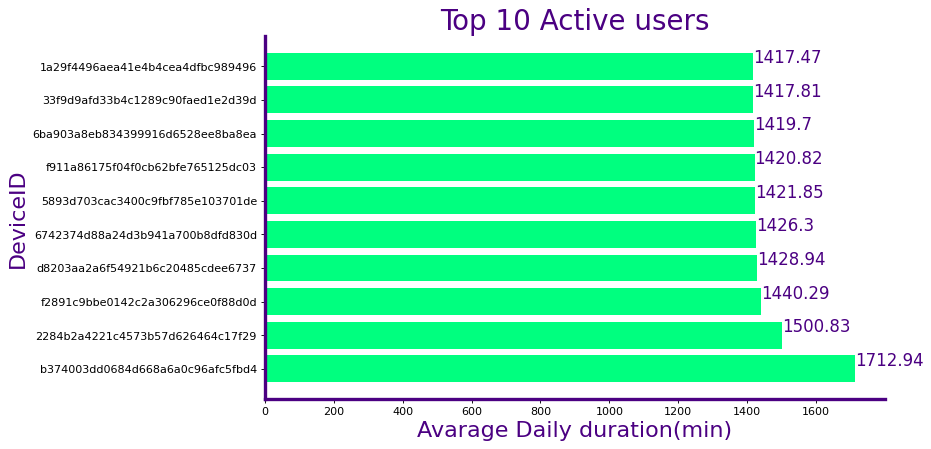

In [500]:
fig, ax = plt.subplots(figsize=(10,6),dpi=80)
ax.barh(df_pandas['deviceID'][:10], df_pandas['average_duration'][:10],color = 'springgreen');
    
for i in ax.patches:
      ax.text(i.get_width()+0.2, i.get_y()+0.5,(i.get_width()),fontsize = 15,color ='indigo') 
            
#labels & title
ax.set_title('Top 10 Active users',fontsize = 25, color = 'indigo')
ax.set_ylabel('DeviceID',color ='indigo',size = "20")
ax.set_xlabel('Avarage Daily duration(min)',color ='indigo',size = "20") 

#ax design
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("indigo")
for axi in ['top','right']:  
    ax.spines[axi].set_color(None)
    

''

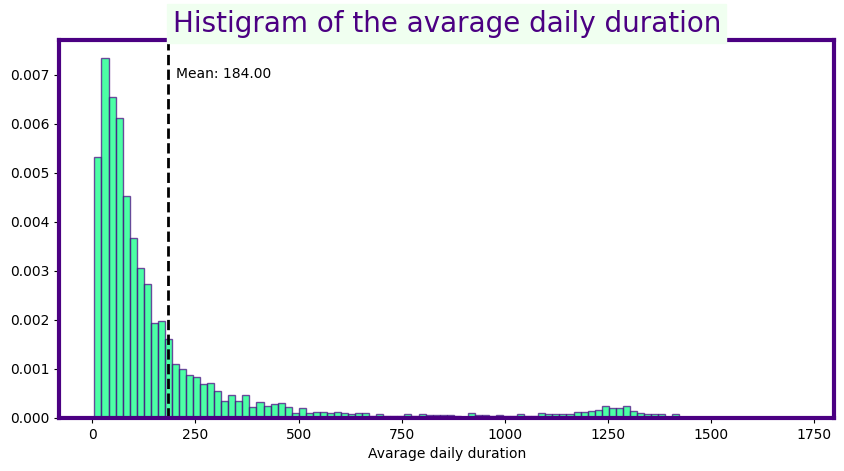

In [501]:
fig, ax = plt.subplots(figsize=(10, 5),dpi=100)

# Histogram of avarage_duration
n, bins, patches = ax.hist(df_pandas['average_duration'], 100,density = 1,color = 'springgreen',edgecolor='indigo',alpha = 0.7)

# Adding mean line to histogram
ax.axvline(df_pandas['average_duration'].mean(), color='black', linestyle='dashed', linewidth=2)

# Adding mean value to histogram
min_ylim, max_ylim = plt.ylim()
ax.text(df_pandas['average_duration'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pandas['average_duration'].mean()))

ax.set_xlabel('Avarage daily duration')
ax.set_title('Histigram of the avarage daily duration',fontsize = 20, color = 'indigo', backgroundcolor = 'honeydew')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("indigo")

;

A session's average duration is 184 minutes for this app.